In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;  
}

<IPython.core.display.Javascript object>

In [2]:
import sys
sys.path.append('/Users/af/Work/code/mcmc/build')
#sys.path.append('/Users/af/Work/code/mcmc/debug')

import mcmc
#help(mcmc)
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [3]:
def gauss_dist(x, mu=0, sigma=1):    
    sigma = np.array(sigma)
    mu = np.array(mu)
    return 1/(np.multiply(sigma,np.sqrt(2*np.pi))) * np.exp(-(x-mu)**2/(2*sigma**2))


def dg(x, alpha=0.5, mu_1=-3, sigma_1=1, mu_2=3, sigma_2=1):
    return alpha*gauss_dist(x, mu_1,sigma_1 )+(1-alpha)*gauss_dist(x, mu_2,sigma_2 )


def dist_andreas(x, alpha=5):
    return np.exp(-(np.cos(-(x-alpha)+(-x+alpha)**2)-1)-0.1*(-x+alpha)**4)/6.90815481092748


def my_sampling(nTrials, xmin, xmax, dist_true, **params):
    
    x = np.linspace(xmin, xmax, 3000)
    max_dist = np.max(dist_true(x, **params))
    
    samplesTrial = xmin+(np.random.rand(nTrials)*(xmax-xmin))
    #only accecpt samples with a random y-coord from [0..something larger than maximum of curve] under the curve
    samples = samplesTrial[ 1.1*max_dist*np.random.rand(nTrials) < dist_true(samplesTrial, **params)]
    
    return samples, samplesTrial


def true_dist(case=0):
    if case==0:# Gaussian w. zero mean and 1 variance
        dist = lambda x: gauss_dist(x, mu=0, sigma=1)
        xmin = -5
        xmax=5
    if case==1: # Double Gaussian 
        dist = lambda x: dg(x, alpha=0.5, mu_1=-3, sigma_1=1, mu_2=3, sigma_2=1)
        xmin = -8
        xmax = 8
    if case==2: # Andreas' dist
        dist = lambda x: dist_andreas(x, alpha=5)
        xmin=1
        xmax=9
    
    return dist, xmin, xmax


def generate_noisy_sample(N=1000, case_dist=0, case_err=0, seed=1234):
    
    """
    N : number of points
    case_dist :  case for distribution of mass (x)
                0 :: gaussian mu=0, sigma=1
                1 :: double gaussian
                2 :: Andreas' dist.

    """
    np.random.seed(seed)   
    
    # Masses
    f, xmin, xmax = true_dist(case_dist)
    x, _ = my_sampling(5*N, xmin, xmax, f)
    Nsamples = x.size
    print('Got %s samples' %Nsamples)
    
    # Redshifts
    z_min=1e-3
    z_max=3
    z = np.linspace(z_min, z_max, Nsamples)
    
    # Errors
    if case_err==0: # quadratic
        sigma = (z/z_max)**2
    if case_err==1: # sqrt
        sigma = (z/z_max)**(1/2)
    
    error = sigma*np.random.normal(size=Nsamples, loc=0, scale=1)
    y = x + error
    
    return y, x, z, sigma, error

Got 2079 samples


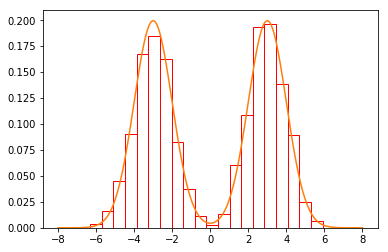

In [36]:
case = 1


y, x, z, sigma, error = generate_noisy_sample(N=1500, case_dist=case, case_err=0)


x_1 = np.linspace(true_dist(case=case)[1], true_dist(case=case)[2], 500)
plt.hist(x, 20, density=True, fill=False, edgecolor='red');
plt.plot(x_1, true_dist(case=case)[0](x_1));





In [40]:
t = mcmc.CoolingTarget(2.5)
#t = mcmc.SimpleTarget()
state = mcmc.State()
samples = mcmc.ProbabilityDistributionSamples(y, sigma)

p = mcmc.PiecewiseConstantPDF(samples, true_dist(case=case)[1],true_dist(case=case)[2],50)

nModes = 2
p2 = mcmc.GaussianMixturePDF(samples, true_dist(case=case)[1],true_dist(case=case)[2], nModes)


print(p.getNames())
prior = mcmc.SmoothnessPrior("pdf", 0.1, 2, 8)

state.add(p)
state.add(p2)
state.add(prior)

t.set_posterior(state)

c = mcmc.Chain(t, 0)

c.run(0,0,3000, 1)
#c.run(1000000,5000,500,100)
#c.run(10,0,20,1)


{'pdf': 0}


[-11499.651 -11287.971 -11205.445 ...  -9030.597  -9030.597  -9030.913]
(2999, 2)
[-4.  4.]


IndexError: index 2 is out of bounds for axis 1 with size 2

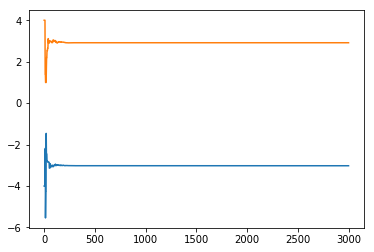

In [41]:
#print(c.getWeights())
print(c.getLoglikes())
#print(c.getSamples("A"))
mu = c.getSamples("mu")
A  = c.getSamples("A")
sig  = c.getSamples("sig")
print(mu.shape)
print(mu[0,:])
plt.plot( mu[:,0] )
plt.plot( mu[:,1] )
plt.plot( mu[:,2] )
plt.plot( mu[:,3] )
plt.show()
plt.plot( A[:,0] )
plt.plot( A[:,1] )
plt.plot( A[:,2] )
plt.plot( A[:,3] )
plt.show()
plt.plot( sig[:,0] )
plt.plot( sig[:,1] )
plt.plot( sig[:,2] )
plt.plot( sig[:,3] )
plt.show()
plt.plot(c.getLoglikes())
plt.show()

plt.hist(c.getSamples("nNonzeroModes"), density=True, bins=np.linspace(-0.5, nModes-0.5, nModes));

[[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 ...
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]
[[-4.         4.       ]
 [-4.         4.       ]
 [-4.         4.       ]
 ...
 [-3.0205815  2.9146848]
 [-3.0205815  2.9146848]
 [-3.0205815  2.9146848]]
[[8.        8.       ]
 [8.        8.       ]
 [8.        8.       ]
 ...
 [1.0398177 0.9963124]
 [1.0398177 0.9963124]
 [1.0398177 0.9963124]]
(2999, 2)
[0.5 0.5]



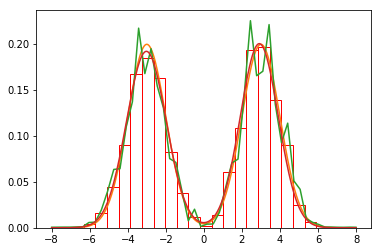

In [42]:
X = c.getSamples("pdf")
A = c.getSamples("A")
mu = c.getSamples("mu")
sig = c.getSamples("sig")
#A = c.getSamples("A")[-1]
#mu = c.getSamples("mu")[-1]
#sig = c.getSamples("sig")[-1]
print(A)
print(mu)
print(sig)
print(mu.shape)

mixture_mean = lambda x : np.mean(np.sum(A[np.newaxis, :,:]*np.exp(-(x[:,np.newaxis,np.newaxis]-mu[np.newaxis, :,:])**2/(2*sig[np.newaxis, :,:]**2))/(np.sqrt(2*np.pi)*sig[np.newaxis,:,:]),2),1)
mixture_last = lambda x : np.sum(A[np.newaxis, -1,:]*np.exp(-(x[:,np.newaxis]-mu[np.newaxis, -1,:])**2/(2*sig[np.newaxis, -1,:]**2))/(np.sqrt(2*np.pi)*sig[np.newaxis,-1,:]),1)
meanx = np.mean(X, 0)

print(A[-1,:])
print()

x_2 = np.linspace(true_dist(case=case)[1], true_dist(case=case)[2], meanx.shape[0])
plt.hist(x, 20, density=True, fill=False, edgecolor='red');
plt.plot(x_1, true_dist(case=case)[0](x_1));
plt.plot(x_2, meanx)
plt.plot(x_1, mixture_last(x_1))




In [8]:
X = c.getSamples("position")


weights = c.getWeights()


# Extract x and y
x = X[:, 0]
y = X[:, 1]
# Define the borders
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
print(xmin, xmax, ymin, ymax)
# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

import scipy.stats as st
from sklearn.datasets.samples_generator import make_blobs

positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)



fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cfset = ax.contourf(xx, yy, f, cmap='coolwarm')
ax.imshow(np.rot90(f), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
#cset = ax.contour(xx, yy, f, colors='k')
#ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title('2D Gaussian Kernel density estimation')

IndexError: index 0 is out of bounds for axis 1 with size 0

In [ ]:
XY = c.getSamples("x and y")

print(XY.shape)

weights = c.getWeights()
print(weights.shape)


# Extract x and y
x = XY[:, 0]
y = XY[:, 1]

print(x)
print(y)

z = c.getSamples("z")
w = c.getSamples("w")
wsq = c.getSamples("wsq")

#h =plt.hist2d(x, y, 40, weights = weights, cmin = 0)
#plt.colorbar(h[3])




In [ ]:
plt.hist(z[:], bins=20,density=True,weights=weights[:])

xc = np.linspace(-3,3,100)
plt.plot(xc,np.exp(-(xc**2/2))/np.sqrt(2*np.pi))

In [ ]:

t = mcmc.SimpleTarget()
#t = mcmc.CoolingTarget(20)
A = mcmc.A()
B = mcmc.B()
C = mcmc.C()
D = mcmc.D()

state = mcmc.State()
state.sharedDependencyMaxDepth = 3

state.add(A)
state.add(B)
state.add(C)
state.add(D)

#samples = mcmc.ProbabilityDistributionSamples(y, sigma)
#p = mcmc.PiecewiseConstantPDF(samples, -4,4,40)
#s.add(p)
t.set_posterior(state)

c = mcmc.Chain(t, 0)
#c.run(1,0,70,1)

c.run(100000,10000,10000,1)



In [ ]:
plt.plot(c.getLoglikes())


In [ ]:
help(mcmc)